# Final Testing

Here, we train and test LR, RF, and CNN using the output of notebook #104.

In [226]:
import sklearn.linear_model, numpy, matplotlib.pyplot as plt, seaborn, h5py, sklearn.ensemble, keras.models
from collections import defaultdict
from crowdastro.crowd.util import balanced_accuracy
%matplotlib inline

norris_labelled_sets = ['RGZ & Norris & compact', 'RGZ & Norris & resolved', 'RGZ & Norris']
rgz_labelled_sets = ['RGZ & Norris & compact', 'RGZ & Norris & resolved', 'RGZ & Norris',
                     'RGZ & compact', 'RGZ & resolved', 'RGZ']
zid_to_radio_url = {}
zid_to_ir_url = {}
with open('/Users/alger/data/RGZ/zooniverse_id_to_urls.csv') as f:
    for row in f:
        zid, radio, ir = row.strip().split(',')
        zid_to_radio_url[zid] = radio[:20] + radio[20:].replace('radio', 'contours').replace('png', 'json')
        zid_to_ir_url[zid] = ir

## Training logistic regression

In [ ]:
def train_lr():
    with h5py.File('/Users/alger/data/Crowdastro/all_training_data_22_05_17.h5', 'r') as f:
        features = f['features'].value
        features[:, -1024:] = numpy.arcsinh(features[:, -1024:] / 0.1) / numpy.arcsinh(1 / 0.1)
        norris_labels = f['norris_labels'].value
        rgz_labels = f['rgz_labels'].value

        lr_norris_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        lr_norris_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        lr_norris_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        lr_norris_classifiers = defaultdict(list)  # Maps set -> classifiers.
        for set_name in norris_labelled_sets:
            print('Norris: {}'.format(set_name))
            for train, test in zip(f['/sets/{}/train'.format(set_name)].value,
                                   f['/sets/{}/test'.format(set_name)].value):
                lr = sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l1')
                lr.fit(features[train], norris_labels[train])
                predictions = lr.predict(features[test])
                probabilities = lr.predict_proba(features[test])
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                lr_norris_predictions[set_name].append(predictions)
                lr_norris_predicted_probs[set_name].append(probabilities)
                lr_norris_accuracies[set_name].append(accuracy)
                lr_norris_classifiers[set_name].append(lr)

        lr_rgz_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        lr_rgz_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        lr_rgz_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        lr_rgz_classifiers = defaultdict(list)  # Maps set -> classifiers.
        set_name_to_norris_set = {
            'RGZ & compact': 'RGZ & Norris & compact',
            'RGZ & resolved': 'RGZ & Norris & resolved',
            'RGZ': 'RGZ & Norris',
            'RGZ & Norris & compact': 'RGZ & Norris & compact',
            'RGZ & Norris & resolved': 'RGZ & Norris & resolved',
            'RGZ & Norris': 'RGZ & Norris',
        }
        for set_name in rgz_labelled_sets:
            print('RGZ: {}'.format(set_name))
            for train, test in zip(f['/sets/{}/train'.format(set_name)].value,
                                   f['/sets/{}/test'.format(set_name_to_norris_set[set_name])].value):
                lr = sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l1')
                lr.fit(features[train], rgz_labels[train])
                predictions = lr.predict(features[test])
                probabilities = lr.predict_proba(features[test])
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                lr_rgz_predictions[set_name].append(predictions)
                lr_rgz_predicted_probs[set_name].append(probabilities)
                lr_rgz_accuracies[set_name].append(accuracy)
                lr_rgz_classifiers[set_name].append(lr)
        
        return lr_norris_predictions, lr_norris_predicted_probs, lr_norris_accuracies, lr_norris_classifiers, \
               lr_rgz_predictions, lr_rgz_predicted_probs, lr_rgz_accuracies, lr_rgz_classifiers

In [229]:
lr_norris_predictions, lr_norris_predicted_probs, lr_norris_accuracies, lr_norris_classifiers, \
lr_rgz_predictions, lr_rgz_predicted_probs, lr_rgz_accuracies, lr_rgz_classifiers = train_lr()

Norris: RGZ & Norris & compact
Norris: RGZ & Norris & resolved
Norris: RGZ & Norris
RGZ: RGZ & Norris & compact
RGZ: RGZ & Norris & resolved
RGZ: RGZ & Norris
RGZ: RGZ & compact
RGZ: RGZ & resolved
RGZ: RGZ


## Training random forests


In [240]:
def train_rf():
    import scipy.stats
    with h5py.File('/Users/alger/data/Crowdastro/all_training_data_22_05_17.h5', 'r') as f:
        features = f['features'].value
        features[:, -1024:] = numpy.arcsinh(features[:, -1024:] / 0.1) / numpy.arcsinh(1 / 0.1)
        norris_labels = f['norris_labels'].value
        rgz_labels = f['rgz_labels'].value

        rf_norris_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        rf_norris_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        rf_norris_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        rf_norris_classifiers = defaultdict(list)  # Maps set -> classifiers.
        for set_name in norris_labelled_sets:
            print('Norris: {}'.format(set_name))
            for train, test in zip(f['/sets/{}/train'.format(set_name)].value,
                                   f['/sets/{}/test'.format(set_name)].value):
                rf = sklearn.ensemble.RandomForestClassifier(
                    class_weight='balanced', criterion='entropy', bootstrap=True, max_depth=8,
                    min_weight_fraction_leaf=0.01)
                rf.fit(features[train], norris_labels[train])
                predictions = rf.predict(features[test])
                probabilities = rf.predict_proba(features[test])
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                rf_norris_predictions[set_name].append(predictions)
                rf_norris_predicted_probs[set_name].append(probabilities)
                rf_norris_accuracies[set_name].append(accuracy)
                rf_norris_classifiers[set_name].append(rf)

        rf_rgz_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        rf_rgz_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        rf_rgz_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        rf_rgz_classifiers = defaultdict(list)  # Maps set -> classifiers.
        set_name_to_norris_set = {
            'RGZ & compact': 'RGZ & Norris & compact',
            'RGZ & resolved': 'RGZ & Norris & resolved',
            'RGZ': 'RGZ & Norris',
            'RGZ & Norris & compact': 'RGZ & Norris & compact',
            'RGZ & Norris & resolved': 'RGZ & Norris & resolved',
            'RGZ & Norris': 'RGZ & Norris',
        }
        for set_name in rgz_labelled_sets:
            print('RGZ: {}'.format(set_name))
            for train, test in zip(f['/sets/{}/train'.format(set_name)].value,
                                   f['/sets/{}/test'.format(set_name_to_norris_set[set_name])].value):
                rf = sklearn.ensemble.RandomForestClassifier(
                    class_weight='balanced', criterion='entropy', bootstrap=True, max_depth=8,
                    min_samples_leaf=45)
                rf.fit(features[train], rgz_labels[train])
                predictions = rf.predict(features[test])
                probabilities = rf.predict_proba(features[test])
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                rf_rgz_predictions[set_name].append(predictions)
                rf_rgz_predicted_probs[set_name].append(probabilities)
                rf_rgz_accuracies[set_name].append(accuracy)
                rf_rgz_classifiers[set_name].append(rf)
        
        return rf_norris_predictions, rf_norris_predicted_probs, rf_norris_accuracies, rf_norris_classifiers, \
               rf_rgz_predictions, rf_rgz_predicted_probs, rf_rgz_accuracies, rf_rgz_classifiers

In [241]:
rf_norris_predictions, rf_norris_predicted_probs, rf_norris_accuracies, rf_norris_classifiers, \
rf_rgz_predictions, rf_rgz_predicted_probs, rf_rgz_accuracies, rf_rgz_classifiers = train_rf()

Norris: RGZ & Norris & compact
Norris: RGZ & Norris & resolved
Norris: RGZ & Norris
RGZ: RGZ & Norris & compact
RGZ: RGZ & Norris & resolved
RGZ: RGZ & Norris
RGZ: RGZ & compact
RGZ: RGZ & resolved
RGZ: RGZ


## Running a "Perfect" Classifier

In [242]:
def train_gt():
    with h5py.File('/Users/alger/data/Crowdastro/all_training_data_22_05_17.h5', 'r') as f:
        features = f['features'].value
        features[:, -1024:] = numpy.arcsinh(features[:, -1024:] / 0.1) / numpy.arcsinh(1 / 0.1)
        norris_labels = f['norris_labels'].value
        rgz_labels = f['rgz_labels'].value

        gt_norris_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        gt_norris_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        gt_norris_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        gt_norris_classifiers = defaultdict(list)  # Maps set -> classifiers.
        for set_name in norris_labelled_sets:
            print('Norris: {}'.format(set_name))
            for train, test in zip(f['/sets/{}/train'.format(set_name)].value,
                                   f['/sets/{}/test'.format(set_name)].value):
                predictions = norris_labels[test]
                probabilities = norris_labels[test].astype(float)
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                gt_norris_predictions[set_name].append(predictions)
                gt_norris_predicted_probs[set_name].append(probabilities)
                gt_norris_accuracies[set_name].append(accuracy)
                gt_norris_classifiers[set_name].append(None)

        gt_rgz_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        gt_rgz_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        gt_rgz_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        gt_rgz_classifiers = defaultdict(list)  # Maps set -> classifiers.
        set_name_to_norris_set = {
            'RGZ & compact': 'RGZ & Norris & compact',
            'RGZ & resolved': 'RGZ & Norris & resolved',
            'RGZ': 'RGZ & Norris',
            'RGZ & Norris & compact': 'RGZ & Norris & compact',
            'RGZ & Norris & resolved': 'RGZ & Norris & resolved',
            'RGZ & Norris': 'RGZ & Norris',
        }
        for set_name in rgz_labelled_sets:
            print('RGZ: {}'.format(set_name))
            for train, test in zip(f['/sets/{}/train'.format(set_name)].value,
                                   f['/sets/{}/test'.format(set_name_to_norris_set[set_name])].value):
                predictions = rgz_labels[test]
                probabilities = rgz_labels[test].astype(float)
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                gt_rgz_predictions[set_name].append(predictions)
                gt_rgz_predicted_probs[set_name].append(probabilities)
                gt_rgz_accuracies[set_name].append(accuracy)
                gt_rgz_classifiers[set_name].append(None)
        
        return gt_norris_predictions, gt_norris_predicted_probs, gt_norris_accuracies, gt_norris_classifiers, \
               gt_rgz_predictions, gt_rgz_predicted_probs, gt_rgz_accuracies, gt_rgz_classifiers

In [243]:
gt_norris_predictions, gt_norris_predicted_probs, gt_norris_accuracies, gt_norris_classifiers, \
gt_rgz_predictions, gt_rgz_predicted_probs, gt_rgz_accuracies, gt_rgz_classifiers = train_gt()

Norris: RGZ & Norris & compact
Norris: RGZ & Norris & resolved
Norris: RGZ & Norris
RGZ: RGZ & Norris & compact
RGZ: RGZ & Norris & resolved
RGZ: RGZ & Norris
RGZ: RGZ & compact
RGZ: RGZ & resolved
RGZ: RGZ


## Running CNNs

In [255]:
def run_cnn():
    with h5py.File('/Users/alger/data/Crowdastro/all_training_data_22_05_17.h5', 'r') as f:
        features = f['features'].value
        features[:, -1024:] = numpy.arcsinh(features[:, -1024:] / 0.1) / numpy.arcsinh(1 / 0.1)
        im_features = features[:, -1024:].reshape((-1, 1, 32, 32))
        as_features = features[:, :-1024]
        norris_labels = f['norris_labels'].value
        rgz_labels = f['rgz_labels'].value

        cnn_norris_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        cnn_norris_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        cnn_norris_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        cnn_norris_classifiers = defaultdict(list)  # Maps set -> classifiers.
        set_name_to_cnn_weights = {
            'RGZ & Norris & compact': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_norris_compact.h5',
            'RGZ & Norris & resolved': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_norris_resolved.h5',
            'RGZ & Norris': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_norris.h5',
        }
        for set_name in norris_labelled_sets:
            print('Norris: {}'.format(set_name))
            for i, test in enumerate(f['/sets/{}/test'.format(set_name)].value):
                with open('/Users/alger/data/Crowdastro/model_22_05_17_5conv.json', 'r') as model:
                    cnn = keras.models.model_from_json(model.read())
                try:
                    cnn.load_weights(set_name_to_cnn_weights[set_name].format(i))
                except:
                    print('\tSkipping {}...'.format(i))
                    continue
                predicted_probs = cnn.predict([as_features[test], im_features[test]])
                predictions = predicted_probs > 0.5
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                cnn_norris_predictions[set_name].append(predictions)
                cnn_norris_predicted_probs[set_name].append(predicted_probs)
                cnn_norris_accuracies[set_name].append(accuracy)
                cnn_norris_classifiers[set_name].append(cnn)

        cnn_rgz_predictions = defaultdict(list)  # Maps set -> 4 x n predictions for each quadrant.
        cnn_rgz_predicted_probs = defaultdict(list)  # Maps set -> 4 x n probabilities for each quadrant.
        cnn_rgz_accuracies = defaultdict(list)  # Maps set -> 4 x 1 balanced accuracies.
        cnn_rgz_classifiers = defaultdict(list)  # Maps set -> classifiers.
        set_name_to_cnn_weights = {
            'RGZ & Norris & compact': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_rgz_compact.h5',
            'RGZ & Norris & resolved': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_rgz_resolved.h5',
            'RGZ & Norris': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_rgz.h5',
            'RGZ & compact': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_rgz_full_compact.h5',
            'RGZ & resolved': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_rgz_full_resolved.h5',
            'RGZ': '/Users/alger/data/Crowdastro/weights_22_05_17/weights_{}_rgz_full.h5',
        }
        for set_name in rgz_labelled_sets:
            print('RGZ: {}'.format(set_name))
            for i, test in enumerate(f['/sets/{}/test'.format(set_name)].value):
                with open('/Users/alger/data/Crowdastro/model_22_05_17_5conv.json', 'r') as model:
                    cnn = keras.models.model_from_json(model.read())
                try:
                    cnn.load_weights(set_name_to_cnn_weights[set_name].format(i))
                except:
                    print('\tSkipping {}...'.format(i))
                    continue
                predicted_probs = cnn.predict([as_features[test], im_features[test]])
                predictions = predicted_probs > 0.5
                accuracy = balanced_accuracy(norris_labels[test], predictions)
                cnn_rgz_predictions[set_name].append(predictions)
                cnn_rgz_predicted_probs[set_name].append(predicted_probs)
                cnn_rgz_accuracies[set_name].append(accuracy)
                cnn_rgz_classifiers[set_name].append(cnn)

        return cnn_norris_predictions, cnn_norris_predicted_probs, cnn_norris_accuracies, \
               cnn_rgz_predictions, cnn_rgz_predicted_probs, cnn_rgz_accuracies

In [256]:
cnn_norris_predictions, cnn_norris_predicted_probs, cnn_norris_accuracies, \
cnn_rgz_predictions, cnn_rgz_predicted_probs, cnn_rgz_accuracies = run_cnn()

(42252, 10) (42252, 1, 32, 32)
Norris: RGZ & Norris & compact
Norris: RGZ & Norris & resolved
Norris: RGZ & Norris
RGZ: RGZ & Norris & compact
RGZ: RGZ & Norris & resolved
RGZ: RGZ & Norris
RGZ: RGZ & compact
RGZ: RGZ & resolved
RGZ: RGZ


FileNotFoundError: [Errno 2] No such file or directory: '/User/alger/repos/crowdastro-projects/ATLAS-CDFS/atlas-ml-ba.pdf'

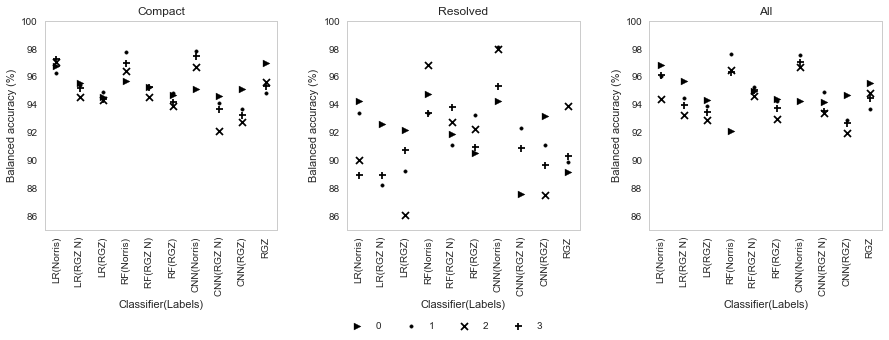

In [257]:
titlemap = {
    'RGZ & Norris & compact': 'Compact',
    'RGZ & Norris & resolved': 'Resolved',
    'RGZ & Norris': 'All',
}

fullmap = {
    'RGZ & Norris & compact': 'RGZ & compact',
    'RGZ & Norris & resolved': 'RGZ & resolved',
    'RGZ & Norris': 'RGZ',
}

markers = ['>', '.', 'x', '+']
handles = []
plt.figure(figsize=(15, 5))
for i, set_name in enumerate(norris_labelled_sets):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(titlemap[set_name])
    for i in range(4):
        handles.append(
            ax.scatter([0], lr_norris_accuracies[set_name][i] * 100, marker=markers[i], color='k'))
        ax.scatter([1], lr_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([2], lr_rgz_accuracies[fullmap[set_name]][i] * 100, marker=markers[i], color='k')
        ax.scatter([3], rf_norris_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([4], rf_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([5], rf_rgz_accuracies[fullmap[set_name]][i] * 100, marker=markers[i], color='k')

        try:
            ax.scatter([6], cnn_norris_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        except IndexError: pass
        try:
            ax.scatter([7], cnn_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        except IndexError: pass
        try:
            ax.scatter([8], cnn_rgz_accuracies[fullmap[set_name]][i] * 100, marker=markers[i], color='k')
        except IndexError: pass
        
        ax.scatter([9],  gt_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')

    ax.set_ylim((85, 100))
    ax.set_xlim((-0.5, 9.5))
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels(['LR(Norris)', 'LR(RGZ N)', 'LR(RGZ)',
                        'RF(Norris)', 'RF(RGZ N)', 'RF(RGZ)',
                        'CNN(Norris)', 'CNN(RGZ N)', 'CNN(RGZ)',
                        'RGZ'
                       ], rotation='vertical')
    plt.xlabel('Classifier(Labels)')
    plt.ylabel('Balanced accuracy (%)')
plt.figlegend(handles, map(str, range(4)), 'lower center', ncol=4)
plt.subplots_adjust(wspace=0.3, bottom=0.3)
plt.savefig('/User/alger/repos/crowdastro-projects/ATLAS-CDFS/atlas-ml-ba.pdf')
plt.show()

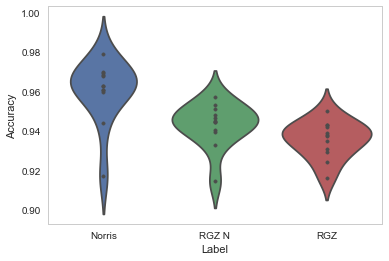

In [231]:
# Plot Norris vs RGZ vs RGZ N.
def plot_labelsets():
    xs = ['Norris', 'RGZ N', 'RGZ']
    ys = []
    y_norris = []
    for accs in [lr_norris_accuracies, rf_norris_accuracies, cnn_norris_accuracies]:
        y_norris.extend(accs['RGZ & Norris'])
    ys.append(y_norris)
    y_rgz = []
    y_rgz_n = []
    for accs in [lr_rgz_accuracies, rf_rgz_accuracies, cnn_rgz_accuracies]:
        y_rgz_n.extend(accs['RGZ & Norris'])
        y_rgz.extend(accs['RGZ'])
    ys.append(y_rgz_n)
    ys.append(y_rgz)
    
    import pandas
    dicts = []
    for x, y in zip(xs, ys):
        for y_ in y:
            dicts.append({'Label': x, 'Accuracy': y_})
    df = pandas.DataFrame(dicts, columns=('Label', 'Accuracy'))
    seaborn.violinplot(data=df, x='Label', y='Accuracy', inner='point')

plot_labelsets()

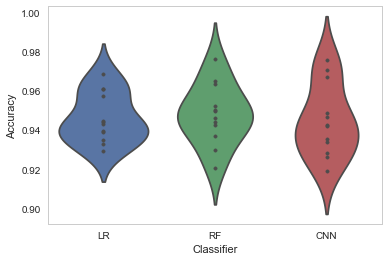

In [258]:
def plot_classifiers():
    xs = ['LR', 'RF', 'CNN']
    ys = []
    
    y_lr = []
    y_lr.extend(lr_norris_accuracies['RGZ & Norris'])
    y_lr.extend(lr_rgz_accuracies['RGZ & Norris'])
    y_lr.extend(lr_rgz_accuracies['RGZ'])
    ys.append(y_lr)
    
    y_rf = []
    y_rf.extend(rf_norris_accuracies['RGZ & Norris'])
    y_rf.extend(rf_rgz_accuracies['RGZ & Norris'])
    y_rf.extend(rf_rgz_accuracies['RGZ'])
    ys.append(y_rf)
    
    y_cnn = []
    y_cnn.extend(cnn_norris_accuracies['RGZ & Norris'])
    y_cnn.extend(cnn_rgz_accuracies['RGZ & Norris'])
    y_cnn.extend(cnn_rgz_accuracies['RGZ'])
    ys.append(y_cnn)
    
    import pandas
    dicts = []
    for x, y in zip(xs, ys):
        for y_ in y:
            dicts.append({'Classifier': x, 'Accuracy': y_})
    df = pandas.DataFrame(dicts, columns=('Classifier', 'Accuracy'))
    seaborn.violinplot(data=df, x='Classifier', y='Accuracy', inner='point')

plot_classifiers()

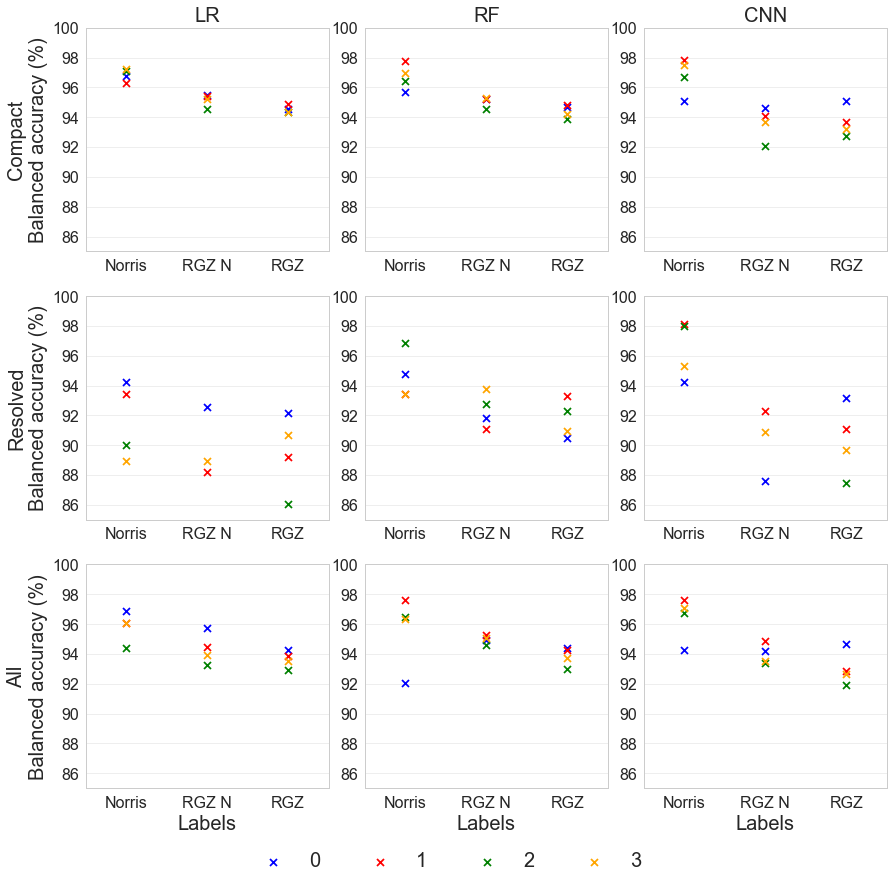

In [259]:
-
#         plt.show()
plot_grid()

In [260]:
def ba_table():
    # Get a table of balanced accuracies.
    titlemap = {
        'RGZ & Norris & compact': 'Compact',
        'RGZ & Norris & resolved': 'Resolved',
        'RGZ & Norris': 'All',
    }
    classifiers = []
    label_sets = []
    data_sets = []
    means = []
    for j, (classifier_name, classifier_set) in enumerate([
            ('LR', [lr_norris_accuracies, lr_rgz_accuracies]),
            ('RF', [rf_norris_accuracies, rf_rgz_accuracies]),
            ('CNN', [cnn_norris_accuracies, cnn_rgz_accuracies]),
    ]):
        for i, set_name in enumerate(norris_labelled_sets):
            for k in range(2):
                mean = numpy.mean(classifier_set[0][set_name]) * 100
                std = numpy.std(classifier_set[0][set_name]) * 100
                classifiers.append(classifier_name)
                label_sets.append(['Norris', 'RGZ'][k])
                data_sets.append(titlemap[set_name])
                means.append('{:.02f} +- {:.02f}'.format(mean, std))
    
    import astropy.table
    table = astropy.table.Table(data=[data_sets, label_sets, classifiers, means],
                                names=['Data set', 'Labeller', 'Classifier', 'Mean Balanced Accuracy (%)'])
    table.sort(keys=['Data set', 'Labeller', 'Classifier'])
    return table

ba_table_ = ba_table()
ba_table_.write('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/atlas-ml-ba.tex', format='latex')

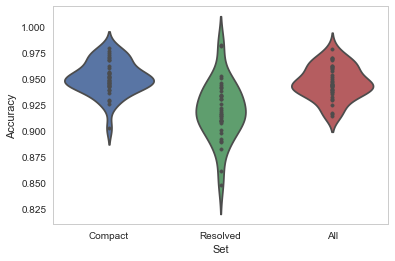

In [235]:
def plot_sets():
    xs = ['Compact', 'Resolved', 'All']
    ys = []
    
    y_compact = []
    y_compact.extend(lr_norris_accuracies['RGZ & Norris & compact'])
    y_compact.extend(lr_rgz_accuracies['RGZ & Norris & compact'])
    y_compact.extend(lr_rgz_accuracies['RGZ & compact'])
    y_compact.extend(cnn_norris_accuracies['RGZ & Norris & compact'])
    y_compact.extend(cnn_rgz_accuracies['RGZ & Norris & compact'])
    y_compact.extend(cnn_rgz_accuracies['RGZ & compact'])
    y_compact.extend(rf_norris_accuracies['RGZ & Norris & compact'])
    y_compact.extend(rf_rgz_accuracies['RGZ & Norris & compact'])
    y_compact.extend(rf_rgz_accuracies['RGZ & compact'])
    ys.append(y_compact)
    
    y_resolved = []
    y_resolved.extend(lr_norris_accuracies['RGZ & Norris & resolved'])
    y_resolved.extend(lr_rgz_accuracies['RGZ & Norris & resolved'])
    y_resolved.extend(lr_rgz_accuracies['RGZ & resolved'])
    y_resolved.extend(cnn_norris_accuracies['RGZ & Norris & resolved'])
    y_resolved.extend(cnn_rgz_accuracies['RGZ & Norris & resolved'])
    y_resolved.extend(cnn_rgz_accuracies['RGZ & resolved'])
    y_resolved.extend(rf_norris_accuracies['RGZ & Norris & resolved'])
    y_resolved.extend(rf_rgz_accuracies['RGZ & Norris & resolved'])
    y_resolved.extend(rf_rgz_accuracies['RGZ & resolved'])
    ys.append(y_resolved)
    
    y_all = []
    y_all.extend(lr_norris_accuracies['RGZ & Norris'])
    y_all.extend(lr_rgz_accuracies['RGZ & Norris'])
    y_all.extend(lr_rgz_accuracies['RGZ'])
    y_all.extend(cnn_norris_accuracies['RGZ & Norris'])
    y_all.extend(cnn_rgz_accuracies['RGZ & Norris'])
    y_all.extend(cnn_rgz_accuracies['RGZ'])
    y_all.extend(rf_norris_accuracies['RGZ & Norris'])
    y_all.extend(rf_rgz_accuracies['RGZ & Norris'])
    y_all.extend(rf_rgz_accuracies['RGZ'])
    ys.append(y_all)
    
    import pandas
    dicts = []
    for x, y in zip(xs, ys):
        for y_ in y:
            dicts.append({'Set': x, 'Accuracy': y_})
    df = pandas.DataFrame(dicts, columns=('Set', 'Accuracy'))
    seaborn.violinplot(data=df, x='Set', y='Accuracy', inner='point')

plot_sets()

## LR Weights Analysis

LR does remarkably well with raw pixels. What weighting does it assign to each pixel?

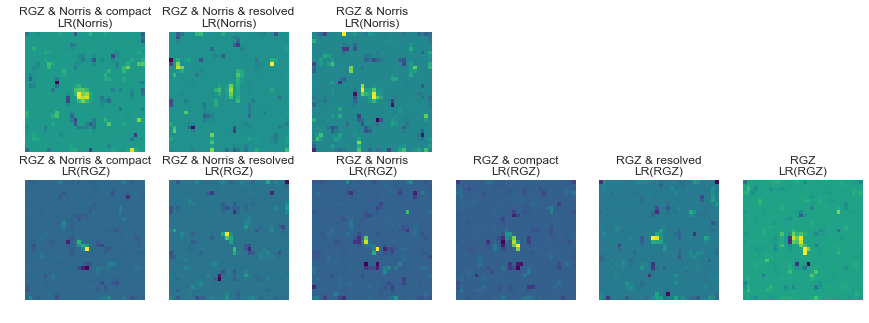

In [247]:
plt.figure(figsize=(15, 5))
for k, (label_str, labellers) in enumerate(zip(
        ['Norris', 'RGZ'],
        [lr_norris_classifiers, lr_rgz_classifiers])):
    for i, subset_str in enumerate(labellers):
        im = numpy.mean(
            [c.coef_[0, -1024:].reshape((32, 32))
             for c in labellers[subset_str]], axis=0)
        plt.subplot(2, 6, 1 + i + k * 6)
        plt.imshow(im, cmap='viridis')
        plt.title(subset_str + '\n' + 'LR({})'.format(label_str))
        plt.axis('off')
plt.show()

## Cross-identification

We will now use these results to generate full cross-identifications for objects in RGZ.

In [248]:
# We first have to convert the returned probabilities into an array of probabilities for each SWIRE object.
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r') as f:
    n_swire = f['/swire/cdfs/numeric'].shape[0]

def output_probs_to_swire_probs(output_probs, test_sets_name):
    # output_probs is a list of arrays of predictions corresponding to the test sets.
    with h5py.File('/Users/alger/data/Crowdastro/all_training_data_01_05_17.h5', 'r') as f:
        test_sets = f['/sets/{}/test'.format(test_sets_name)].value
        swire_probs = numpy.zeros((n_swire,))
        swire_counts = numpy.zeros((n_swire,))
        for output_probs_, test_set in zip(output_probs, test_sets):
            for prob, index in zip(output_probs_, test_set.nonzero()[0]):
                if prob.shape == (2,):
                    prob = prob[1]  # Output is (p(0), p(1)).
                # Running average.
                swire_probs[index] = (swire_probs[index] * swire_counts[index] + prob) / (
                    swire_counts[index] + 1)
                swire_counts[index] += 1
        swire_probs = numpy.ma.MaskedArray(swire_probs, mask=swire_counts == 0)
        return swire_probs

# We'll ignore objects not in Norris.
swire_probs = {}
probs_sets = {
    ('lr', 'norris'): lr_norris_predicted_probs,
    ('rf', 'norris'): rf_norris_predicted_probs,
    ('cnn', 'norris'): cnn_norris_predicted_probs,
    ('lr', 'rgz'): lr_rgz_predicted_probs,
    ('rf', 'rgz'): rf_rgz_predicted_probs,
    ('cnn', 'rgz'): cnn_rgz_predicted_probs,
    ('gt', 'norris'): gt_norris_predicted_probs,
    ('gt', 'rgz'): gt_rgz_predicted_probs,
}
for classifier in ['lr', 'rf', 'cnn', 'gt']:
    for labeller in ['norris', 'rgz']:
        for subset_str in norris_labelled_sets:
            probs = output_probs_to_swire_probs(probs_sets[classifier, labeller][subset_str], subset_str)
            swire_probs[classifier, labeller, subset_str] = probs

swire_probs.keys()

dict_keys([('lr', 'norris', 'RGZ & Norris & compact'), ('lr', 'norris', 'RGZ & Norris & resolved'), ('lr', 'norris', 'RGZ & Norris'), ('lr', 'rgz', 'RGZ & Norris & compact'), ('lr', 'rgz', 'RGZ & Norris & resolved'), ('lr', 'rgz', 'RGZ & Norris'), ('rf', 'norris', 'RGZ & Norris & compact'), ('rf', 'norris', 'RGZ & Norris & resolved'), ('rf', 'norris', 'RGZ & Norris'), ('rf', 'rgz', 'RGZ & Norris & compact'), ('rf', 'rgz', 'RGZ & Norris & resolved'), ('rf', 'rgz', 'RGZ & Norris'), ('cnn', 'norris', 'RGZ & Norris & compact'), ('cnn', 'norris', 'RGZ & Norris & resolved'), ('cnn', 'norris', 'RGZ & Norris'), ('cnn', 'rgz', 'RGZ & Norris & compact'), ('cnn', 'rgz', 'RGZ & Norris & resolved'), ('cnn', 'rgz', 'RGZ & Norris'), ('gt', 'norris', 'RGZ & Norris & compact'), ('gt', 'norris', 'RGZ & Norris & resolved'), ('gt', 'norris', 'RGZ & Norris'), ('gt', 'rgz', 'RGZ & Norris & compact'), ('gt', 'rgz', 'RGZ & Norris & resolved'), ('gt', 'rgz', 'RGZ & Norris')])

In [77]:
# Compute a SWIRE KD-Tree for quickly looking up candidate hosts.
import scipy.spatial
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r') as f:
    swire_coords = f['/swire/cdfs/numeric'][:, :2]
    swire_names = numpy.array([i.decode('ascii') for i in f['/swire/cdfs/string'].value])
swire_tree = scipy.spatial.KDTree(swire_coords)

In [78]:
def cross_identify(zid, probabilities, radius: 'degrees'=1 / 60):
    # Where is this object?
    import astropy.io.ascii as asc
    table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
    row = table[table['Component Zooniverse ID (RGZ)'] == zid][0]
    ra, dec = row['Component RA (Franzen)'], row['Component DEC (Franzen)']
    # What SWIRE objects are nearby?
    nearby = swire_tree.query_ball_point([ra, dec], radius)
    # Corresponding probabilities.
    nearby_probabilities = probabilities[nearby]
    # Return the probabilities and SWIRE names/coords.
    import astropy.table
    return astropy.table.Table(
        data=[swire_names[nearby], swire_coords[nearby, 0], swire_coords[nearby, 1],
              nearby_probabilities],
        names=['name', 'ra', 'dec', 'prob'])

In [91]:
import astropy.io.ascii as asc
import astropy.io.fits as fits, astropy.wcs
import astropy.modeling.functional_models, astropy.modeling.fitting
def compact_cross_identify(zid, radius: 'degrees'=1 / 60):
    atlas = fits.open('/Users/alger/data/ATLAS/CDFSmosaic_allch_8March2015.fits')[0]
    wcs = astropy.wcs.WCS(atlas.header).dropaxis(3).dropaxis(2)
    table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
    # Where is this object?
    row = table[table['Component Zooniverse ID (RGZ)'] == zid][0]
    ra, dec = row['Component RA (Franzen)'], row['Component DEC (Franzen)']
    # What's the closest SWIRE object?
    distance, nearest = swire_tree.query([ra, dec])
    if distance > 5 / 60 / 60:  # 5 arcsec
        return None
    return swire_names[nearest]
#     # What SWIRE objects are nearby?
#     nearby = swire_tree.query_ball_point([ra, dec], radius)
#     # Find the Gaussian peak.
#     py, px = [int(i) for j in wcs.all_world2pix([[ra, dec]], 1) for i in j]
#     w = int(radius * 60 * 25)  # px
#     im = atlas.data[0, 0, px - w:px + w, py - w:py + w]
#     x, y = numpy.meshgrid(range(im.shape[0]), range(im.shape[1]))
#     im_flat = numpy.vstack([x.ravel(), y.ravel(), im.ravel()]).T
#     g = astropy.modeling.functional_models.Gaussian2D(x_mean=25, y_mean=25)
#     fitter = astropy.modeling.fitting.LevMarLSQFitter()
#     g = fitter(g, *im_flat.T)
#     sx, sy = (g.x_mean.value, g.y_mean.value)
#     # Convert back to RA/Dec.
#     (ra, dec), = wcs.all_pix2world([[sy - w + py, sx - w + px]], 1)
#     dist, index = swire_tree.query((ra, dec))
#     return swire_names[index]

In [80]:
# A quick test.
cross_identify('ARG0003sky', swire_probs['lr', 'norris', 'RGZ & Norris'])

name,ra,dec,prob
str26,float32,float32,float64
SWIRE3_J032635.37-280806.1,51.6474,-28.135,6.8216399143e-06
SWIRE3_J032635.58-280817.9,51.6483,-28.1383,6.49668893942e-06
SWIRE3_J032635.62-280757.5,51.6484,-28.1326,0.024769799538
SWIRE3_J032635.88-280827.9,51.6495,-28.1411,0.0176781414949
SWIRE3_J032635.97-280822.4,51.6499,-28.1396,0.000656579568332
SWIRE3_J032637.05-280813.8,51.6544,-28.1372,5.32693696922e-07
SWIRE3_J032636.25-280723.1,51.6511,-28.1231,3.57473912532e-08
SWIRE3_J032636.84-280745.8,51.6535,-28.1294,0.988347773322
SWIRE3_J032636.90-280750.7,51.6538,-28.1308,0.997025093426


### Accuracy

In [92]:
_compact_xids = {}
def test_cross_identifications(classifier, labeller, subset, filter_compact=True):
    import astropy.io.ascii as asc, collections
    table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')

    zids = set()
    zid_to_norris = collections.defaultdict(set)
    zid_to_compact = {}
    for row in table:
        if row['Source SWIRE (Norris)'] and row['Source SWIRE (Norris)'].startswith('SWIRE') and \
                row['Primary Component ID (RGZ)']:
            zid = row['Component Zooniverse ID (RGZ)']
            zids.add(zid)
            zid_to_norris[zid].add(row['Source SWIRE (Norris)'])
            if zid in zid_to_compact:
                zid_to_compact[zid] = False
            S = row['Component S (Franzen)']
            S_ERR = row['Component S_ERR (Franzen)']
            Sp = row['Component Sp (Franzen)']
            Sp_ERR = row['Component Sp_ERR (Franzen)']
            R_ERR2 = 2 * numpy.sqrt((S_ERR / S) ** 2 + (Sp_ERR / Sp) ** 2)
            R = numpy.log(S / Sp)
            if R > R_ERR2:
                zid_to_compact[zid] = False
            else:
                zid_to_compact[zid] = True
    print('Found {:.02%} compact.'.format(sum(zid_to_compact.values()) / len(zid_to_compact)))
    
    n_correct = 0
    n_total = len(zids)
    zid_to_classifier = {}
    for zid in zids:
        xid = None

        if zid_to_compact[zid]:
            # Classify using the compact method.
            if zid in _compact_xids:
                xid = _compact_xids[zid]
            else:
                xid = compact_cross_identify(zid)
                _compact_xids[zid] = xid

        if not zid_to_compact[zid] or xid is None:
            # Classify using the ML method.
            xids = cross_identify(zid, swire_probs[classifier, labeller, subset])
            if len(xids['prob']) == 0:
                continue
            xid = xids['name'][xids['prob'].argmax()]
#         print(zid, xid, zid_to_norris[zid])
        n_correct += xid in zid_to_norris[zid]
        zid_to_classifier[zid] = xid
    return n_correct / n_total, zid_to_classifier

In [93]:
# for classifier in ['lr', 'rf', 'cnn']:swire_probs.keys()
test_cross_identifications('lr', 'norris', 'RGZ & Norris')

Found 78.89% compact.


(0.8872950819672131,
 {'ARG0003r17': 'SWIRE3_J032733.99-284621.2',
  'ARG0003r18': 'SWIRE3_J033409.03-282412.3',
  'ARG0003r1a': 'SWIRE3_J033126.14-281838.1',
  'ARG0003r1b': 'SWIRE3_J032845.74-282709.3',
  'ARG0003r1c': 'SWIRE3_J033553.33-272740.4',
  'ARG0003r1d': 'SWIRE3_J033527.50-271950.8',
  'ARG0003r1e': 'SWIRE3_J032916.14-272347.8',
  'ARG0003r1f': 'SWIRE3_J033131.63-283135.7',
  'ARG0003r1g': 'SWIRE3_J033204.88-274647.6',
  'ARG0003r1h': 'SWIRE3_J033242.24-273814.9',
  'ARG0003r1i': 'SWIRE3_J033431.07-282525.8',
  'ARG0003r1j': 'SWIRE3_J033051.41-273013.7',
  'ARG0003r1k': 'SWIRE3_J032941.22-280811.6',
  'ARG0003r1l': 'SWIRE3_J033048.51-283857.7',
  'ARG0003r1m': 'SWIRE3_J033310.18-274842.4',
  'ARG0003r1n': 'SWIRE3_J033522.58-275548.6',
  'ARG0003r1o': 'SWIRE3_J033034.56-282707.7',
  'ARG0003r1p': 'SWIRE3_J033021.89-280206.1',
  'ARG0003r1q': 'SWIRE3_J033323.78-272407.0',
  'ARG0003r1r': 'SWIRE3_J032949.13-273149.1',
  'ARG0003r1s': 'SWIRE3_J033429.74-271745.2',
  'ARG0003r1t

In [ ]:
# Compute all the cross-identification accuracies.
cross_id_results = {}
for key in swire_probs.keys():
    print(key)
    cross_id_results[key] = test_cross_identifications(*key)

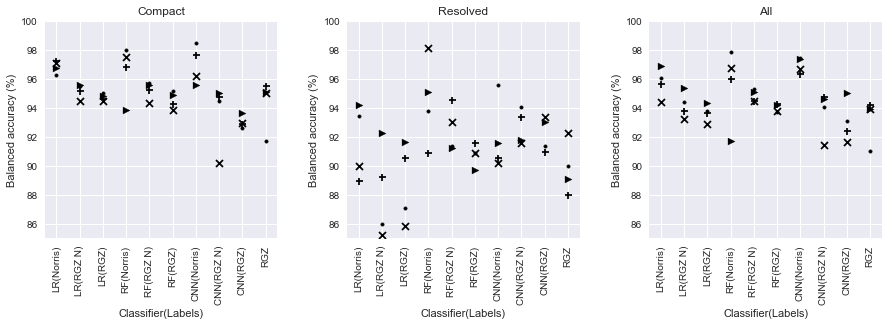

In [94]:
# Plot cross-identification accuracy.
markers = ['>', '.', 'x', '+']
plt.figure(figsize=(15, 4))
for i, set_name in enumerate(norris_labelled_sets):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(titlemap[set_name])
    for i in range(4):
        ax.scatter([0], lr_norris_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([1], lr_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([2], lr_rgz_accuracies[fullmap[set_name]][i] * 100, marker=markers[i], color='k')
        ax.scatter([3], rf_norris_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([4], rf_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([5], rf_rgz_accuracies[fullmap[set_name]][i] * 100, marker=markers[i], color='k')
        ax.scatter([6], cnn_norris_accuracies[set_name][i] * 100, marker=markers[i], color='k')

        ax.scatter([7], cnn_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')
        ax.scatter([8], cnn_rgz_accuracies[fullmap[set_name]][i] * 100, marker=markers[i], color='k')
        
        ax.scatter([9],  gt_rgz_accuracies[set_name][i] * 100, marker=markers[i], color='k')

    ax.set_ylim((85, 100))
    ax.set_xlim((-0.5, 9.5))
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels(['LR(Norris)', 'LR(RGZ N)', 'LR(RGZ)',
                        'RF(Norris)', 'RF(RGZ N)', 'RF(RGZ)',
                        'CNN(Norris)', 'CNN(RGZ N)', 'CNN(RGZ)',
                        'RGZ'
                       ], rotation='vertical')
    plt.xlabel('Classifier(Labels)')
    plt.ylabel('Balanced accuracy (%)')
plt.subplots_adjust(wspace=0.3)
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/atlas-ml-ba.pdf')
plt.show()

In [95]:
# What we really want is a plot of this for visualisation.
def plot_cross_identification(zid, swire_probs, plot_scatter=True, ax=None):
    import astropy.io.fits, astropy.wcs, astropy.io.ascii, requests, skimage.io, skimage.transform
    import matplotlib.patches as patches
    probs_table = cross_identify(zid, swire_probs)
    # Where is the ATLAS object?
    table = astropy.io.ascii.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
    row = table[table['Component Zooniverse ID (RGZ)'] == zid][0]
    ra, dec = row['Component RA (Franzen)'], row['Component DEC (Franzen)']
    # Load the RGZ images.
    ir = skimage.io.imread(zid_to_ir_url[zid])
    radio = requests.get(zid_to_radio_url[zid]).json()['contours']
    # Convert SWIRE objects into pixel locations.
    ras = probs_table['ra']
    decs = probs_table['dec']
    ras -= ra
    decs -= dec
    ras *= 60 * 250 * 0.9
    decs *= 60 * 250
    ras += 250
    decs += 250
    ras = 500 - ras
    decs = 500 - decs
    if not ax:
        fig = plt.figure(figsize=(15, 7.5))
        ax = fig.add_subplot(1, 2 if plot_scatter else 1, 1)
    ax.imshow(ir, origin='upper', alpha=0.5)
    for contour in radio:
        for contour_ in contour:
            xs = []
            ys = []
            for point in contour_['arr']:
                xs.append(point['x'] * 500 / 201)
                ys.append(point['y'] * 500 / 201)
            plt.plot(xs, ys, c='white', zorder=1)
    sizes = [max(i, 10) for i in probs_table['prob']**2 * 200]
    probs = [i for i in probs_table['prob']]
    plt.scatter(ras, decs, s=sizes, zorder=2,
         color='black', facecolor='white',
         linewidth=1)
    plt.grid('off')
    w = 32 * 500 / 140
    plt.axis('off')
    top_n = [i for i in numpy.argsort(probs_table['prob'])[-5:] if probs_table['prob'][i] > 0.2]
    indices = {i:j + 1 for j, i in enumerate(numpy.argsort(probs_table['prob'])[::-1])}
    for i, (ra, dec) in enumerate(zip(ras, decs)):
        if plot_scatter:
            plt.text(ra + 12, dec + 12, str(indices[i]), color="black", fontsize=12)

        if i not in top_n:
            continue

        ax.add_patch(
            patches.Rectangle(
                (ra - w / 2, dec - w / 2),   # (x, y)
                w,          # width
                w,          # height
                facecolor='None',
                linestyle='--',
                edgecolor='white',
                linewidth=2,
            )
        )
    if plot_scatter and not ax:
        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(range(1, len(probs_table) + 1), sorted(probs, reverse=True), s=sorted(sizes, reverse=True))
        ax.invert_xaxis()

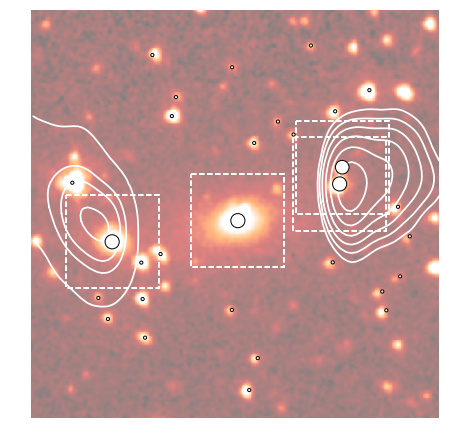

In [261]:
plot_cross_identification(
    'ARG0003sky', swire_probs['cnn', 'norris', 'RGZ & Norris'],
    plot_scatter=False)

Let's plot some of these against their resolved-ness, which is $S/S_p$. For now we'll just set both axes to that; we would like to add a disagreement axis (but that will require some way of disagreeing — a committee might work.)

In [319]:
def resolvedness(r):
    aa = 10.0
    bb = 1.3
    s = r['Component S (Franzen)'] if r['Component S (Franzen)'] != 0.0 else r['Component Sp (Franzen)']
    ssp = s / r['Component Sp (Franzen)']
    aasnrbb = aa / (r['Component SNR (Franzen)'] ** bb)
    return ssp / aasnrbb

def plot_by_resolved():
    import astropy.io.ascii
    table = astropy.io.ascii.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
    zid_to_resolvedness = {}
    for row in table:
        if row['Source SWIRE (Norris)'] and row['Source SWIRE (Norris)'].startswith('SWIRE') and \
                row['Primary Component ID (RGZ)']:
            zid = row['Component Zooniverse ID (RGZ)']
            res = resolvedness(row)
            zid_to_resolvedness[zid] = res
    
    zids = sorted(zid_to_resolvedness, key=zid_to_resolvedness.get)
    resolvednesses = numpy.array([zid_to_resolvedness[zid] for zid in zids])
    resolvednesses_original = resolvednesses.copy()
#     print(resolvednesses)
    seaborn.distplot(resolvednesses)
    plt.yscale('log')
#     print((resolvednesses == 1).sum())
    
#     for i, (zid, res) in enumerate(zip(zids, resolvednesses * 100)):
#         print(zid, i, res)
#         fig = plt.figure(figsize=(10, 10))
#         ax = fig.add_subplot(1, 1, 1)
#         plot_cross_identification(zid, swire_probs['lr', 'norris', 'RGZ & Norris'], ax=ax, plot_scatter=False)
#         # Hacks: http://stackoverflow.com/a/27227718/1105803
#         ax.set_axis_off()
#         plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
#                             hspace=0, wspace=0)
#         plt.margins(0, 0)
#         ax.xaxis.set_major_locator(plt.NullLocator())
#         ax.yaxis.set_major_locator(plt.NullLocator())
#         plt.savefig('/Users/alger/data/Crowdastro/cross_id_plots/{}.pdf'.format(zid),
#                     bbox_inches='tight', pad_inches=0)
#         plt.close()

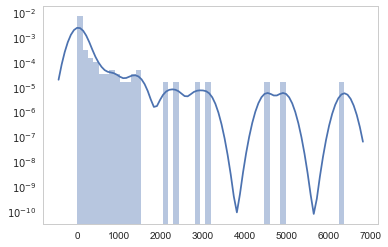

In [320]:
plot_by_resolved()
# table = astropy.io.ascii.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
# for i in table:
#     print(i['Component S (Franzen)'], i['Component Zooniverse ID (RGZ)'], i['Component ID (Franzen)'])

## Export

Export the CNN predictions.

In [ ]:
def export():
    cnn_norris_output_predictions = numpy.zeros((len(swire_names),))
    lr_norris_output_predictions = numpy.zeros((len(swire_names),))
    rf_norris_output_predictions = numpy.zeros((len(swire_names),))
    cnn_rgz_output_predictions = numpy.zeros((len(swire_names),))
    lr_rgz_output_predictions = numpy.zeros((len(swire_names),))
    rf_rgz_output_predictions = numpy.zeros((len(swire_names),))
    with h5py.File('/Users/alger/data/Crowdastro/all_training_data_11_05_17.h5', 'r') as f:
        test_sets = f['/sets/{}/test'.format('RGZ & Norris')].value
    for test_set, probs in zip(test_sets, cnn_norris_predicted_probs['RGZ & Norris']):
        cnn_norris_output_predictions[test_set] = probs.ravel()
    for test_set, probs in zip(test_sets, lr_norris_predicted_probs['RGZ & Norris']):
        lr_norris_output_predictions[test_set] = probs[:, 1]
    for test_set, probs in zip(test_sets, rf_norris_predicted_probs['RGZ & Norris']):
        rf_norris_output_predictions[test_set] = probs[:, 1]
    for test_set, probs in zip(test_sets, cnn_rgz_predicted_probs['RGZ & Norris']):
        cnn_rgz_output_predictions[test_set] = probs.ravel()
    for test_set, probs in zip(test_sets, lr_rgz_predicted_probs['RGZ & Norris']):
        lr_rgz_output_predictions[test_set] = probs[:, 1]
    for test_set, probs in zip(test_sets, rf_rgz_predicted_probs['RGZ & Norris']):
        rf_rgz_output_predictions[test_set] = probs[:, 1]
    with h5py.File('/Users/alger/data/Crowdastro/predictions_swire_11_05_17.h5', 'w') as f:
        f.create_dataset('cnn_norris', data=cnn_norris_output_predictions)
        f.create_dataset('lr_norris', data=lr_norris_output_predictions)
        f.create_dataset('cnn_rgz', data=cnn_rgz_output_predictions)
        f.create_dataset('lr_rgz', data=lr_rgz_output_predictions)
        f.create_dataset('rf_rgz', data=rf_rgz_output_predictions)
        f.create_dataset('rf_norris', data=rf_norris_output_predictions)
export()

## Feature ablation

## Quadrants map

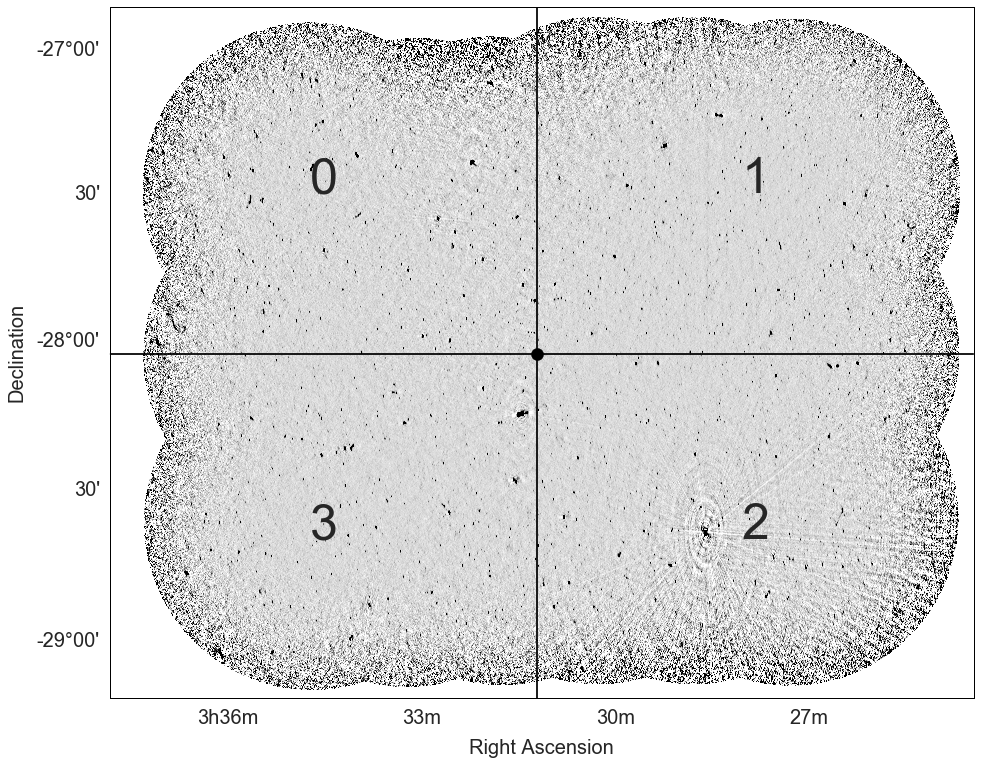

In [170]:
def plot_quadrants():
#     middle = (52.8, -28.1)
#     (q == 0 and coords[0] >= middle[0] and coords[1] >= middle[1]) or
#     (q == 1 and coords[0] < middle[0] and coords[1] >= middle[1]) or
#     (q == 2 and coords[0] < middle[0] and coords[1] < middle[1]) or
#     (q == 3 and coords[0] >= middle[0] and coords[1] < middle[1]))
    import astropy.io.fits, astropy.wcs, astropy.visualization, matplotlib.patches
    import astropy.visualization.wcsaxes
    atlas = astropy.io.fits.open('/Users/alger/data/ATLAS/CDFSmosaic_allch_8March2015.fits')[0]
    wcs = astropy.wcs.WCS(atlas.header).dropaxis(3).dropaxis(2)
    fig = plt.figure(figsize=(15, 15))
    ax = astropy.visualization.wcsaxes.WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=wcs)
    fig.add_axes(ax)
    stretch = astropy.visualization.ManualInterval(-100e-6, 300e-6)
    ax.imshow(stretch(atlas.data[0, 0]), cmap='Greys')
    ax.set_xlim((1500, 8500))
    ax.set_ylim((1700, 7300))
    middle, = wcs.all_world2pix([(52.8, -28.1)], 1)
    ax.scatter([middle[0]], [middle[1]], s=150, c='black', marker='o')
    ax.axvline(middle[0], color='black')
    ax.axhline(middle[1], color='black')
    plt.text((1500 + middle[0]) / 2,
             (7300 + middle[1]) / 2,
             '0', {'fontsize': 50, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    plt.text((8500 + middle[0]) / 2,
             (7300 + middle[1]) / 2,
             '1', {'fontsize': 50, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    plt.text((8500 + middle[0]) / 2,
             (1700 + middle[1]) / 2,
             '2', {'fontsize': 50, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    plt.text((1500 + middle[0]) / 2,
             (1700 + middle[1]) / 2,
             '3', {'fontsize': 50, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    lon, lat = ax.coords
    lon.set_ticklabel(size=20)
    lat.set_ticklabel(size=20)
    lon.set_major_formatter('hh:mm')
    lon.set_axislabel('Right Ascension', size=20)
    lat.set_axislabel('Declination', size=20)
    plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/quadrants.pdf')

plot_quadrants()